In [2]:
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser, Namespace
import argparse
from datetime import datetime
import json
import os

from simple_parsing import subparsers
from sklearn.covariance import shrunk_covariance
from src.dataset import make_corewise_bk_dataloaders
from src.experiment_setup import setup, ExperimentUtility
import torch
from src.prostnfound import ProstNFound
from src.sam_wrappers import build_medsam
from src.loss import CancerDetectionValidRegionLoss, MaskedPredictionModule
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, ChainedScheduler, LambdaLR
import torch.amp
from src.utils import calculate_metrics
import numpy as np
from tqdm import tqdm
from src.slurm import add_submitit_args, submit_job
import matplotlib.pyplot as plt


args = Namespace()
args.batch_size = 1
args.fold = 1
args.num_folds = 5
args.device = 'cuda'


# ======== DATA =========
train, val, test = make_corewise_bk_dataloaders(
    batch_sz=args.batch_size, style="last_frame", fold=args.fold, num_folds=args.num_folds, 
)

import pandas as pd

table_train = train.dataset.table
table_val = val.dataset.table
table_test = test.dataset.table

table_train["split"] = "train"
table_val["split"] = "val"
table_test["split"] = "test"

table = pd.concat([table_train, table_val, table_test])
#table.to_csv(os.path.join(args.exp_dir, "metadata.csv"), index=False)

train_ids = table_train.patient_id.unique()
val_ids = table_val.patient_id.unique()
test_ids = table_test.patient_id.unique()

assert set(train_ids).isdisjoint(val_ids)
assert set(train_ids).isdisjoint(test_ids)
assert set(val_ids).isdisjoint(test_ids)

# ======== MODEL =========

CHECKPOINT = "/h/pwilson/projects/prostNfoundBK/logs/2024-07-15_10-59-50/checkpoints/state.pt"

sam_backbone = build_medsam()
model = ProstNFound(sam_backbone, auto_resize_image_to_native=False).to(args.device)
model.load_state_dict(torch.load(CHECKPOINT)["model"])

# torch.compile(model)
loss_fn = CancerDetectionValidRegionLoss(
    loss_pos_weight=2.0,
)

Train: 1553
Val: 343
Test: 335
center
QUEENS    932
UBC       621
Name: count, dtype: int64
Found 1553 files.
Found 343 files.
Found 334 files.


In [3]:
from train_prostnfound_bk import prepare_batch, run_epoch

def extract_all_pixel_predictions(model: ProstNFound, loader, device):
    pixel_labels = []
    pixel_preds = []
    core_ids = []

    model.eval()
    model.to(device)

    for i, batch in enumerate(tqdm(loader)):
        with torch.no_grad():
            
            img, needle, prostate, label, core_id = prepare_batch(batch, device)
            
            # run the model
            heatmap_logits = model(
                img
            )

            # compute predictions
            masks = (prostate > 0.5) & (needle > 0.5)

            predictions, batch_idx = MaskedPredictionModule()(heatmap_logits, masks)

            labels = torch.zeros(len(predictions), device=predictions.device)
            for i in range(len(predictions)):
                labels[i] = label[batch_idx[i]]
            pixel_preds.append(predictions.cpu())
            pixel_labels.append(labels.cpu())

            core_ids.extend(core_id[batch_idx[i]] for i in range(len(predictions)))

    pixel_preds = torch.cat(pixel_preds)
    pixel_labels = torch.cat(pixel_labels)

    return pixel_preds, pixel_labels, core_ids


pixel_preds, pixel_labels, core_ids = extract_all_pixel_predictions(model, val, args.device)

  0%|          | 0/343 [00:00<?, ?it/s]

100%|██████████| 343/343 [02:31<00:00,  2.26it/s]


In [56]:
from torch import nn 
from torch.optim import LBFGS

core_ids = np.array(core_ids)

# fit temperature and bias to center and scale the predictions
print("Fitting temperature calibration on validation outputs.")
temp = nn.Parameter(torch.ones(1))
bias = nn.Parameter(torch.zeros(1))

optim = LBFGS([temp, bias], lr=1e-3, max_iter=100, line_search_fn="strong_wolfe")

# weight the loss to account for class imbalance
pos_weight = (1 - pixel_labels).sum() / pixel_labels.sum()
# encourage sensitivity over specificity
pos_weight *= 1.6

def closure():
    optim.zero_grad()
    logits = pixel_preds / temp + bias
    loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)(logits[:, 0], pixel_labels)
    loss.backward()
    return loss

for _ in range(10):
    print(optim.step(closure))

# make temperature calibrated model
tc_layer = nn.Conv2d(1, 1, 1)
tc_layer.weight.data[0, 0, 0, 0] = temp.data
tc_layer.bias.data[0] = bias.data

class TCModel(nn.Module):
    def __init__(self, model, tc_layer):
        super().__init__()
        self.model = model
        self.tc_layer = tc_layer

    def forward(self, x, *args, **kwargs):
        x = self.model(x, *args, **kwargs)
        x = self.tc_layer(x)
        return x

tc_model = TCModel(model, tc_layer).cuda()



Fitting temperature calibration on validation outputs.
tensor(1.4612, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [57]:
def get_core_predictions_from_pixel_predictions(pixel_preds, pixel_labels, core_ids):
    data = []
    for core in np.unique(core_ids):
        mask = core_ids == core
        core_pred = pixel_preds[mask].sigmoid().mean().item()
        core_label = pixel_labels[mask][0].item()
        data.append({"core_id": core, "core_pred": core_pred, "core_label": core_label})

    df = pd.DataFrame(data)
    return df

pixel_preds_tc = pixel_preds / temp + bias
val_outputs = get_core_predictions_from_pixel_predictions(
    pixel_preds_tc, pixel_labels, core_ids
)

In [58]:
calculate_metrics(val_outputs.core_pred, val_outputs.core_label)

{'auc': 0.8034311012728279,
 'sens_at_20_spe': 0.9846153846153847,
 'sens_at_40_spe': 0.9692307692307692,
 'sens_at_60_spe': 0.8,
 'sens_at_80_spe': 0.5846153846153846,
 'f1': 0.5}

core_label
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: core_pred, dtype: object

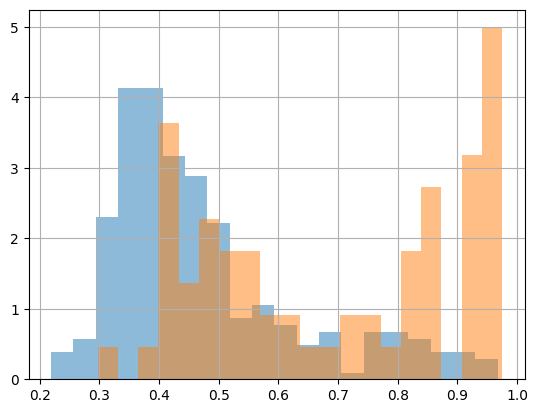

In [59]:
val_outputs.groupby('core_label').core_pred.hist(bins=20, alpha=0.5, density=True)

In [15]:
val_metrics, val_tracker = run_epoch(
    val,
    model, 
    loss_fn, 
    None, 
    None, 
    None, 
    device=args.device, 
    train=False
)

100%|██████████| 343/343 [02:30<00:00,  2.27it/s]


In [24]:
def make_predictions_dataframe(predictions, core_ids, core_info_dict): 
    d = []
    for i, (core_id, prediction) in enumerate(zip(core_ids, predictions)): 
        d.append({
            "core_id": core_id, 
            "prediction": prediction.item(), 
            **core_info_dict[core_id]
        })
    return pd.DataFrame(d)

def get_core_info_dict(table): 
    table = table.set_index("core_id")
    return table.to_dict(orient="index")

def get_core_predictions_from_pixel_predictions(pixel_preds, pixel_labels, core_ids):
    data = []
    for core in np.unique(core_ids):
        mask = core_ids == core
        core_pred = pixel_preds[mask].sigmoid().mean().item()
        core_label = pixel_labels[mask][0].item()
        data.append({"core_id": core, "core_pred": core_pred, "core_label": core_label})

    df = pd.DataFrame(data)
    return df

In [25]:
core_ids, predictions = val_tracker.get()
core_info_dict = get_core_info_dict(val.dataset.table)
df = make_predictions_dataframe(predictions, core_ids, core_info_dict)
df.to_csv("val_predictions.csv", index=False)

In [60]:
img, needle, prostate, label, core_id = prepare_batch(next(iter(val)), args.device)
logits = model(img)
probs = logits.sigmoid().detach().cpu().numpy()[0][0]
img = img.detach().cpu().numpy()[0][0]
prostate = prostate.detach().cpu().numpy()[0][0]

plt.imshow(probs, vmin=0, vmax=1, alpha=0.5 * prostate, cmap="hot")

OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 

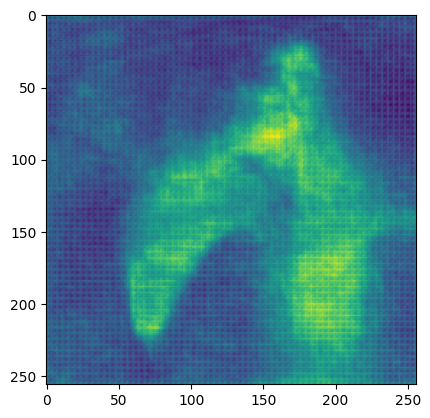

In [62]:
del tc_model

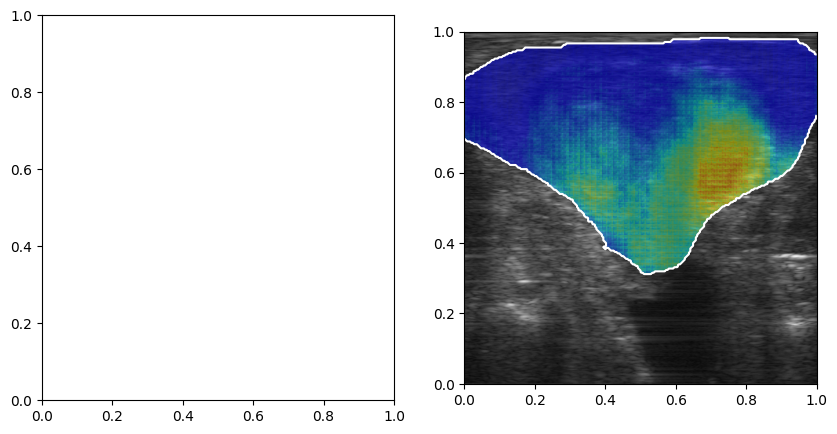

In [15]:
from itertools import islice


batch = next(iter(islice(val, 2, 10)))

img, needle, prostate, label, core_id = prepare_batch(batch, args.device)
logits = model(img)
probs = logits.sigmoid().detach().cpu().numpy()[0][0]

img = img.detach().cpu().numpy()[0][0]
prostate = prostate.detach().cpu().numpy()[0][0]
needle = needle.detach().cpu().numpy()[0][0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.imshow(img, cmap="gray", extent=[0, 1, 0, 1])
plt.imshow(probs, vmin=0, vmax=1, alpha=0.5 * prostate, cmap="jet", extent=[0, 1, 0, 1])
plt.contour(np.flip(prostate, 0), colors="white", extent=[0, 1, 0, 1])

TypeError: 'NoneType' object is not subscriptable

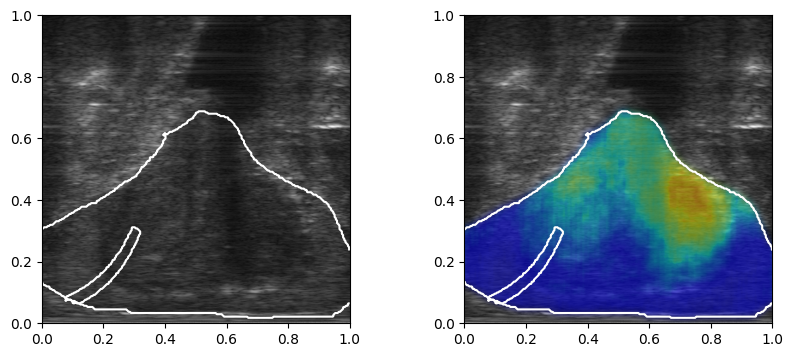

In [25]:
from skimage.transform import resize
from skimage.morphology import dilation
from skimage.filters import gaussian


def render_heatmap_v2(heatmap, bmode, prostate_mask, needle_mask, metadata): 
    cmap = "gray"

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    extent=(0, 1, 0, 1)

    heatmap_logits = np.flip(heatmap.copy(), axis=0)
    bmode = np.flip(bmode, axis=0)
    prostate_mask = np.flip(prostate_mask, axis=0)
    needle_mask = np.flip(needle_mask, axis=0)

    prostate_mask_for_alpha = resize(prostate_mask, (heatmap_logits.shape[0], heatmap_logits.shape[1]), order=0)
    # expand the prostate mask
    prostate_mask_for_alpha = dilation(prostate_mask_for_alpha)
    prostate_mask_for_alpha = gaussian(prostate_mask_for_alpha, sigma=3)
    
    heatmap_logits = gaussian(heatmap_logits, sigma=1)

    ax[1].imshow(bmode, extent=extent, cmap=cmap)
    
    ax[1].imshow(heatmap_logits, vmin=0, vmax=1, extent=extent, cmap='jet', alpha=prostate_mask_for_alpha*0.5)
    ax[1].contour(np.flip(prostate_mask, 0), extent=extent, colors="white")
    ax[1].contour(np.flip(needle_mask, 0), extent=extent, colors="white")

    ax[0].imshow(bmode, extent=extent, cmap=cmap)
    ax[0].contour(np.flip(prostate_mask, 0), extent=extent, colors="white")
    ax[0].contour(np.flip(needle_mask, 0), extent=extent, colors="white")

    fig.suptitle(f'Core {metadata["core_id"]} Grade {metadata["grade"]} Involvement {metadata["pct_cancer"]} Center {metadata["center"]}')

    for a in ax:
        a.axis('off')

    fig.tight_layout()


render_heatmap_v2(probs, img, prostate, needle, None)

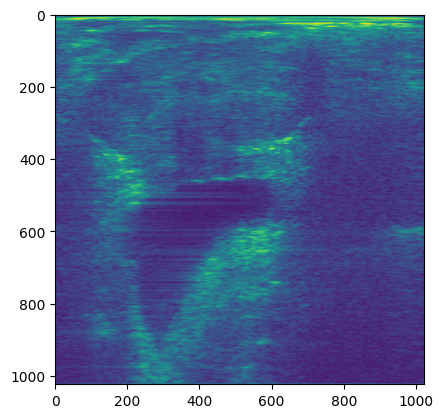

In [38]:
plt.imshow(img.detach().cpu().numpy()[0][0])

In [26]:
val_metrics

{'auc': 0.7744881018262314,
 'sens_at_20_spe': 0.9846153846153847,
 'sens_at_40_spe': 0.9230769230769231,
 'sens_at_60_spe': 0.8,
 'sens_at_80_spe': 0.5384615384615384,
 'f1': 0.4722222222222222,
 'histogram': <wandb.sdk.data_types.image.Image at 0x7fc673604230>,
 'roc_curve': <wandb.sdk.data_types.image.Image at 0x7fc67342a540>,
 'auc_high_inv': 0.8038283658787255,
 'sens_at_20_spe_high_inv': 1.0,
 'sens_at_40_spe_high_inv': 0.9285714285714286,
 'sens_at_60_spe_high_inv': 0.8214285714285714,
 'sens_at_80_spe_high_inv': 0.6071428571428571,
 'f1_high_inv': 0.30985915492957744,
 'histogram_high_inv': <wandb.sdk.data_types.image.Image at 0x7fc67373f3b0>,
 'roc_curve_high_inv': <wandb.sdk.data_types.image.Image at 0x7fc6733f2540>}

label
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: prediction, dtype: object

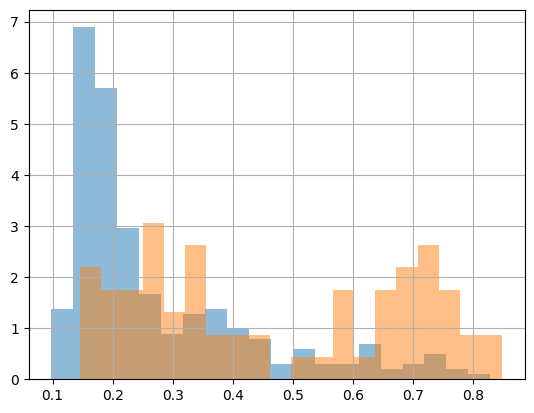

In [29]:
df.groupby('label').prediction.hist(bins=20, alpha=0.5, density=True)

In [12]:
core_ids

['81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 '81.8',
 